CPP: success
1.8945821162883523
  30 :       2.6996        -0.9874        -0.5068  
  31 :       2.5449        -1.1421        -0.6615  
  32 :       2.3871        -1.2998        -0.8192  
  33 :       2.2262        -1.4608        -0.9802  
  34 :       2.0621        -1.6249        -1.1443  
  35 :       1.8946        -1.7923        -1.3114  
  36 :       1.7234        -1.9632        -1.4791  
  37 :       1.5452        -2.1383        -1.6244  
  38 :       1.3312        -2.3203        -1.5485  
  39 :       0.8804        -2.4451         0.0000  
  40 :       0.0000         0.0000         0.0000  


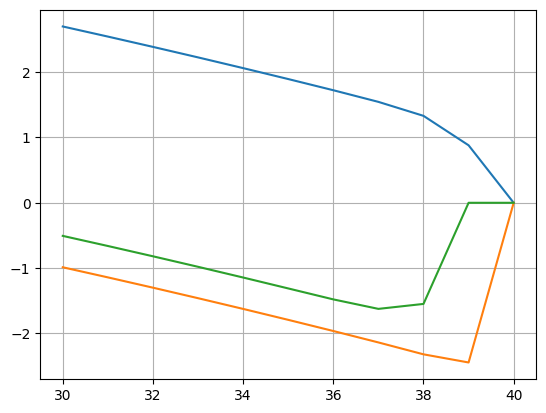

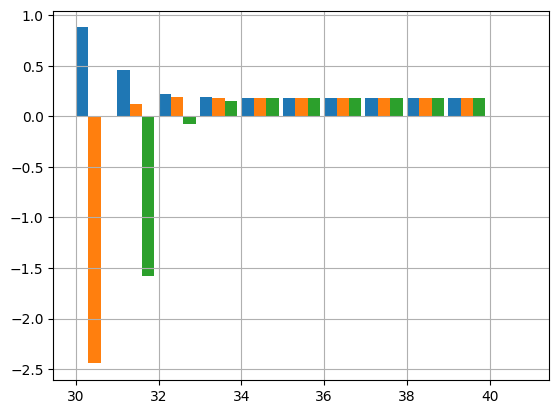

In [8]:
# 
# This is an implementation of the markov model in discrete time
# Pls consult the lecture notes for details
# 

import numpy as np
import matplotlib.pyplot as plt
import time

class Markov:
    def __init__(self,bCPP=True):
        self.bCPP = bCPP
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
        self.iNrTimesPerPeriod = 1.
        self.bRecalculateTime = False
        self.psymM = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        #print("..",self.iNrStates,self.iMaxTime)
        try:
            import markovlv as mlv
            if self.bCPP:
                print("CPP: success")
                self.psymM = mlv.MARKOVLV(self.iMaxTime,self.iMaxTime,1)
                self.psymM.vSetNrStates(iNrStates)
                return()
        except:
            print("Falling Back")
        for i in range(iMaxTime):
                tempPij = np.zeros([iNrStates,iNrStates])
                tempPost = np.zeros([iNrStates,iNrStates])
                tempPre = np.zeros([iNrStates])
                tempDK = np.zeros([iNrStates])
                tempCF = np.zeros([iNrStates])
                self.dPij.append(tempPij)
                self.dPost.append(tempPost)
                self.dPre.append(tempPre)
                self.dDK.append(tempDK)
                self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    
    def vSetDiscount(self,fIRate):
        vTemp = 1./(1.+fIRate)
        #print("Discount %.4f"%(vTemp))
        #print (self.iMaxTime, len(self.dv))
        for i in range(self.iMaxTime):
            if self.psymM:
                for j in range(self.iNrStates):
                    self.psymM.dSetDisc(i, j, j, vTemp)
            else:
                self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPij(t,i,j,fValue)
        else:
            self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def vGetPij(self,t,i,j):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetGetData(True)
            dValue = self.psymM.dSetPij(t,i,j,0)
            self.psymM.vSetGetData(False)
        else:
            dValue =self.dPij[t][i,j]
        print("P_(%d,%d)(%d) =%10.6e"%(i,j,t,dValue))

    def dGetPij(self,t,i,j):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetGetData(True)
            dValue = self.psymM.dSetPij(t,i,j,0)
            self.psymM.vSetGetData(False)
        else:
            dValue =self.dPij[t][i,j]
        return(dValue)
    
    def vSetPre(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPre(t,i,j,fValue)
        else:
            self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPost(t,i,j,fValue)
        else:
            self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def pymBlowMeUp(self,iNrTimesPerPeriod,DefaultStateMapper = dict()):
        psymM = Markov()
        psymM.vDefineModel(self.iNrStates,iMaxTime=self.iMaxTime*iNrTimesPerPeriod)
        psymM.iNrTimesPerPeriod = iNrTimesPerPeriod
        psymM.bRecalculateTime = False
        self.vDoBlowUpStates(psymM,DefaultStateMapper) #To be done ie adjustment of v, P_ij, Pre and Post
        return(psym)
    
    def vDoBlowUpStates(self,psymM,DefaultStateMapper):
        for i in range(self.iNrStates):
            if i not in DefaultStateMapper.keys():
                print("Use %d to itself as default mapper"%(i))
                DefaultStateMapper[i] = i
        fIRate = 1./self.dv[0] - 1.
        psymM.vSetDiscount(fIRate)
        for t in range(self.iMaxTime):
            t0 = self.iMaxTime *self.iNrTimesPerPeriod
            t1 = t0 + self.iNrTimesPerPeriod
            for i in range(self.iNrStates):
                x=[t0*1,t1*1]
                y=[self.dPre[t][i],self.dPost[t][i,i]]
                newval = np.interp(list(range(t0,t1+1))*1., x, y)
                dPDefault  = 1.
                PTemp = np.zeros(self.iNrStates)
                for l in range(self.iNrStates):
                    if l == DefaultStateMapper[i]: continue
                    dTemp = self.dPij[t][i,l] / self.iNrTimesPerPeriod
                    dPDefault  -= dTemp
                    PTemp[l] = dTemp
                PTemp[DefaultStateMapper[i]] = PTemp[l]  
                for k in range(t1-t0):
                    psymM.vSetPre(t0+k,i,i,newval[k])
                    psymM.vSetPij(t0+k,i,l,PTemp[l])
                    for l in range(self.iNrStates):
                        if i == l: continue
                        psymM.vSetPost(t0+k,i,l,self.dPost[t][i,l])
                psymM.vSetPost(t1-1,i,i,newval[-1])
                
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    def dGetDK(self,iStart,iStop,iAge,iState):       
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetStartTime(iStart)
            self.psymM.vSetStopTime(iStop)
            return(self.psymM.dGetDK(iAge, iState,1))
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetStartTime(iStart)
            self.psymM.vSetStopTime(iStop)
            dT = 0
            for j in range(self.iNrStates):
                dT+=self.psymM.dGetCF(iAge, iState, j)
            return(dT)
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def PrintDKs(self,iStart,iStop):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            if self.bRecalculateTime: 
                strTemp += " %6.3f :"%(i*1./self.iNrTimesPerPeriod)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        if self.bRecalculateTime: 
        #    iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        x = []
        y = []
        for i in range(iStop,iStart+1):
            if self.bRecalculateTime:
                x.append(i*1./self.iNrTimesPerPeriod)
            else:
                x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2, ReqStates = None):
        if self.bRecalculateTime: 
        #    iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        import matplotlib.colors as mcolors
        A= []
        for i in mcolors.TABLEAU_COLORS.keys():
            A.append(i)
        for i in mcolors.BASE_COLORS.keys():
            A.append(i)


        
        xBar =[]
        hBar =[]
        bBar =[]
        cBar =[]
        y = []
        if ReqStates == None: mywidth =  1./self.iNrStates
        else: mywidth =  1./len(ReqStates)

        for i in range(iStop,iStart+1):
            if ReqStates == None:
              for j in range(self.iNrStates):
                xBar.append(i+(0.5+j)*0.9*mywidth)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[min(len(A)-1,j)])

            else:
              for j in ReqStates:
                #print("State ",j," requested for plot")
                xBar.append(i+(0.5+j)*0.9*mywidth)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[min(len(A)-1,j)])
        plt.figure(figNr)
        plt.bar(xBar,hBar,bottom=bBar, width = 0.9*mywidth,color=cBar)
        plt.grid(True)

    def PrintLatex(self,strFileName="out.tex",iStart=120,iStop=0):
        self.psymM.vSetStartTime(iStart)
        self.psymM.vSetStopTime(iStop)
        a=self.psymM.dGetDK(50, 0, 1)
        b=self.psymM.dGetCF(50, 0, 0)
        self.psymM.vPrintTeXFileName(strFileName, True, "Test", False)

class MarkovValidated:
    """
    Wrapper that runs both C++ and Python versions,
    compares results, and returns the C++ result
    (or the Python result if you prefer).
    """

    def __init__(self, eps=1e-10):
        self.eps = eps
        
        # One engine with C++ backend
        self.cpp = Markov(bCPP=True)
        
        # One engine with Python backend
        self.py = Markov(bCPP=False)

    # -----------------------------
    #   Model Definition Delegation
    # -----------------------------
    def vDefineModel(self, iNrStates, iMaxTime=1200):
        self.cpp.vDefineModel(iNrStates, iMaxTime)
        self.py.vDefineModel(iNrStates, iMaxTime)

    def vSetDiscount(self, r):
        self.cpp.vSetDiscount(r)
        self.py.vSetDiscount(r)

    def vSetPij(self, t, i, j, v):
        self.cpp.vSetPij(t, i, j, v)
        self.py.vSetPij(t, i, j, v)

    def vSetPre(self, t, i, j, v):
        self.cpp.vSetPre(t, i, j, v)
        self.py.vSetPre(t, i, j, v)

    def vSetPost(self, t, i, j, v):
        self.cpp.vSetPost(t, i, j, v)
        self.py.vSetPost(t, i, j, v)

    # -----------------------------
    #   Comparison Helpers
    # -----------------------------
    def _check(self, label, cpp_val, py_val):
        diff = abs(cpp_val - py_val)
        if diff > self.eps:
            raise ValueError(
                f"[{label}] Mismatch: C++={cpp_val:.12e}, "
                f"Python={py_val:.12e}, diff={diff:.12e}"
            )

    # -----------------------------
    #   Validated DK and CF access
    # -----------------------------
    def dGetDK(self, iStart, iStop, iAge, iState):
        cpp_val = self.cpp.dGetDK(iStart, iStop, iAge, iState)
        py_val  = self.py.dGetDK(iStart, iStop, iAge, iState)

        self._check("DK", cpp_val, py_val)
        return cpp_val   # or py_val

    def dGetCF(self, iStart, iStop, iAge, iState):
        cpp_val = self.cpp.dGetCF(iStart, iStop, iAge, iState)
        py_val  = self.py.dGetCF(iStart, iStop, iAge, iState)

        self._check("CF", cpp_val, py_val)
        return cpp_val   # or py_val

    def PrintDKs(self,iStart,iStop):
        self.cpp.PrintDKs(iStart,iStop)
   
    
    def PlotDKs(self,iStart,iStop,figNr=1):
       self.cpp.PlotDKs(iStart,iStop,figNr=figNr)
        
    def PlotCFs(self,iStart,iStop,figNr=2, ReqStates = None):
        self.cpp.PlotCFs(iStart,iStop,figNr=figNr, ReqStates = ReqStates)


    def PrintLatex(self,strFileName="out.tex",iStart=120,iStop=0):
        self.cpp.PrintLatex(strFileName=strFileName,iStart=iStart,iStop=iStop)


symM = MarkovValidated()

symM.vDefineModel(3)

symM.vSetDiscount(0.02)

iStart = 40
iStop = 30

for i in range(30,40):
    symM.vSetPij(i,0,0,0.8)
    symM.vSetPij(i,0,1,0.1)
    symM.vSetPij(i,0,2,0.1)
    symM.vSetPij(i,1,0,0.7)
    symM.vSetPij(i,1,1,0.2)
    symM.vSetPij(i,1,2,0.1)
    symM.vSetPij(i,2,0,0.15)
    symM.vSetPij(i,2,1,0.7)
    symM.vSetPij(i,2,2,0.15)
    symM.vSetPre(i,0,0,-0.10)
    symM.vSetPre(i,1,0,0.30)
    symM.vSetPost(i,0,2,10)
    symM.vSetPost(i,1,0,-4)

print(symM.dGetDK(iStart, iStop, 35, 0))
symM.PrintDKs(iStart,iStop)
symM.PlotDKs(iStart,iStop)
symM.PlotCFs(iStart,iStop)       